# SHORT COURSE ON: ***COMPUTER VISION***

In [2]:
!pip install kaggle


In [3]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [4]:
!kaggle datasets download -d amirabdi/car-or-truck -p ./ --unzip


403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/datasets/metadata/amirabdi/car-or-truck


In [5]:
import matplotlib.pyplot as plt

In [6]:
from keras.layers import TFSMLayer, Input, Flatten, Dense
from keras.models import Model
import numpy as np

# Load the SavedModel
pretrained_base = TFSMLayer(
    'cv-course-models/cv-course-models/vgg16-pretrained-base',
    call_endpoint='serving_default'
)

# Input must match SavedModel input
inputs = Input(shape=(128, 128, 3))
x_dict = pretrained_base(inputs)         # returns a dict
x = x_dict['block5_pool']                # extract the tensor
x = Flatten()(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs, outputs)

# Test with dummy input
dummy_input = np.random.rand(1, 128, 128, 3).astype(np.float32)
model(dummy_input)


<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.03534124, 0.19896857, 0.10260609, 0.20582704, 0.04467928,
        0.1090703 , 0.10763211, 0.0195285 , 0.11886214, 0.05748468]],
      dtype=float32)>

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

In [8]:
# Example: Extract features from your dataset
features_train = []
labels_train = []

for images, labels in ds_train:
    feats = pretrained_base(images)['block5_pool'].numpy()  # convert to NumPy
    features_train.append(feats)
    labels_train.append(labels.numpy())

features_train = np.concatenate(features_train, axis=0)
labels_train = np.concatenate(labels_train, axis=0)

# Flatten features
features_train = features_train.reshape(features_train.shape[0], -1)

# Now train a simple Keras model
from keras.models import Sequential
from keras.layers import Dense

model = Sequential([
    Dense(256, activation='relu', input_shape=(features_train.shape[1],)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.fit(features_train, labels_train, epochs=30, batch_size=32)


Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - binary_accuracy: 0.6619 - loss: 0.7974
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - binary_accuracy: 0.8417 - loss: 0.3698
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - binary_accuracy: 0.8760 - loss: 0.3081
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - binary_accuracy: 0.9032 - loss: 0.2541
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - binary_accuracy: 0.9220 - loss: 0.2160
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - binary_accuracy: 0.9348 - loss: 0.1846
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - binary_accuracy: 0.9457 - loss: 0.1563
Epoch 8/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - binary_accuracy: 0.9536 - loss: 0.1363
Epoch 9/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - binary_accuracy: 0.9444 - loss: 0.1416
Epoch 10/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - binary_accuracy: 0.9444 - loss: 0.1441
Epoch 11/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - bin

In [19]:
import numpy as np
from itertools import product

def show_kernel(kernel, label=True, digits=None, text_size=28):
    # Format kernel
    kernel = np.array(kernel)
    if digits is not None:
        kernel = kernel.round(digits)

    # Plot kernel
    cmap = plt.get_cmap('Blues_r')
    plt.imshow(kernel, cmap=cmap)
    rows, cols = kernel.shape
    thresh = (kernel.max()+kernel.min())/2
    # Optionally, add value labels
    if label:
        for i, j in product(range(rows), range(cols)):
            val = kernel[i, j]
            color = cmap(0) if val > thresh else cmap(255)
            plt.text(j, i, val, 
                     color=color, size=text_size,
                     horizontalalignment='center', verticalalignment='center')
    plt.xticks([])
    plt.yticks([])

In [19]:
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3), # activation is None
    # More layers follow
])

In [21]:
model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3, activation='relu')
    # More layers follow
])

In [13]:

!kaggle datasets download -d ryanholbrook/computer-vision-resources -p ./ --unzip


Dataset URL: https://www.kaggle.com/datasets/ryanholbrook/computer-vision-resources
License(s): unknown




  0%|          | 0.00/13.1M [00:00<?, ?B/s]
100%|##########| 13.1M/13.1M [00:00<00:00, 918MB/s]


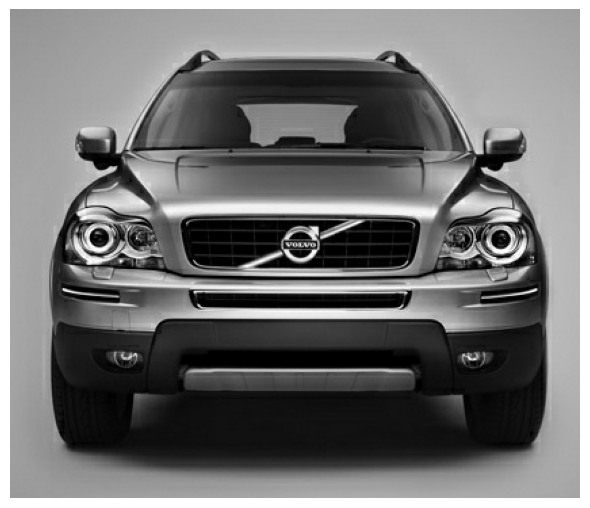

In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

image_path = 'car_feature.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.show();

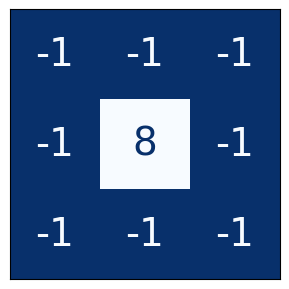

In [21]:
import tensorflow as tf

kernel = tf.constant([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1],
])

plt.figure(figsize=(3, 3))
show_kernel(kernel)


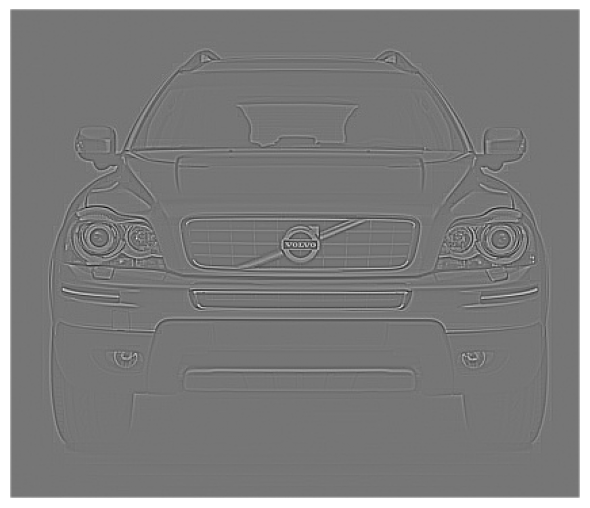

In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load image (already correct in your notebook)
image = tf.io.read_file('car_feature.jpg')
image = tf.io.decode_jpeg(image)

# Convert to float & reshape for conv2d
image = tf.image.convert_image_dtype(image, tf.float32)
image = tf.expand_dims(image, axis=0)  # (1, H, W, 1)

kernel = tf.constant([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1],
], dtype=tf.float32)

kernel = tf.reshape(kernel, [3, 3, 1, 1])  # (kernel_height, kernel_width, in_channels, out_channels)

# Apply convolution
image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    strides=1,
    padding='SAME'
)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_filter), cmap="gray")
plt.axis('off')
plt.show()


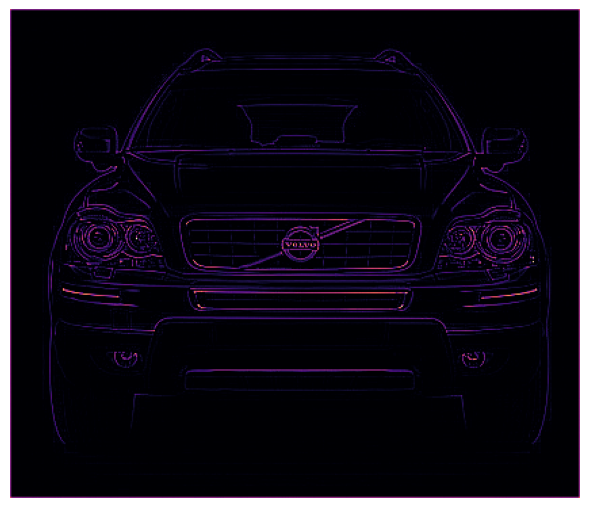

In [27]:
image_detect = tf.nn.relu(image_filter)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.show();

## *`Maximum Pooling`*

In [30]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3), # activation is None
    layers.MaxPool2D(pool_size=2),
    # More layers follow
])


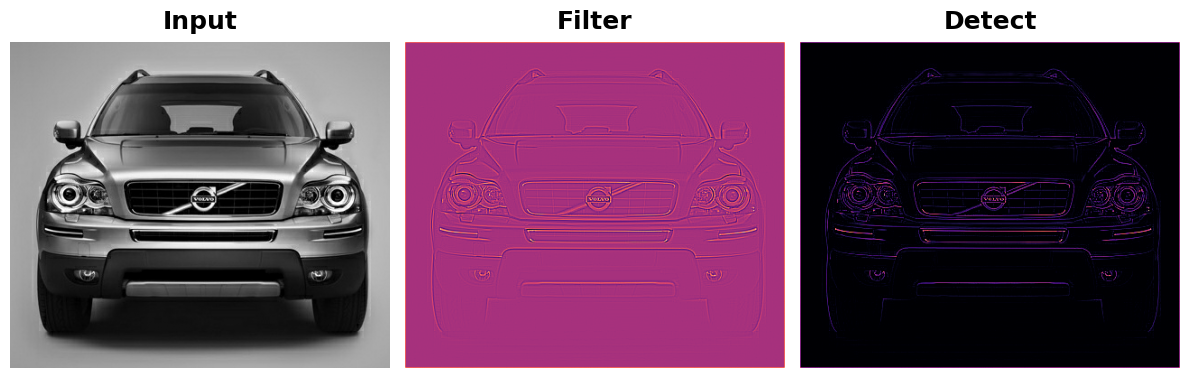

In [34]:
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

# Read image
image_path = 'car_feature.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)

# Define kernel
kernel = tf.constant([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1],
], dtype=tf.float32)

# Reformat for batch compatibility.
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])

# Filter step
image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    # we'll talk about these two in the next lesson!
    strides=1,
    padding='SAME'
)

# Detect step
image_detect = tf.nn.relu(image_filter)
# Show what we have so far
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.title('Input')
plt.subplot(132)
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.title('Filter')
plt.subplot(133)
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title('Detect')
plt.show();

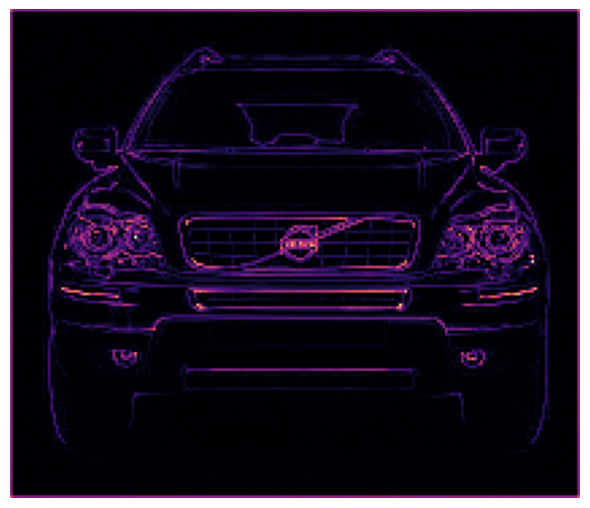

In [36]:
import tensorflow as tf

image_condense = tf.nn.pool(
    input=image_detect, # image in the Detect step above
    window_shape=(2, 2),
    pooling_type='MAX',
    # we'll see what these do in the next lesson!
    strides=(2, 2),
    padding='SAME',
)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_condense))
plt.axis('off')
plt.show();

# Sliding window

In [39]:
import numpy as np
from itertools import product
from skimage import draw, transform

def circle(size, val=None, r_shrink=0):
    circle = np.zeros([size[0]+1, size[1]+1])
    rr, cc = draw.circle_perimeter(
        size[0]//2, size[1]//2,
        radius=size[0]//2 - r_shrink,
        shape=[size[0]+1, size[1]+1],
    )
    if val is None:
        circle[rr, cc] = np.random.uniform(size=circle.shape)[rr, cc]
    else:
        circle[rr, cc] = val
    circle = transform.resize(circle, size, order=0)
    return circle

def show_kernel(kernel, label=True, digits=None, text_size=28):
    # Format kernel
    kernel = np.array(kernel)
    if digits is not None:
        kernel = kernel.round(digits)

    # Plot kernel
    cmap = plt.get_cmap('Blues_r')
    plt.imshow(kernel, cmap=cmap)
    rows, cols = kernel.shape
    thresh = (kernel.max()+kernel.min())/2
    # Optionally, add value labels
    if label:
        for i, j in product(range(rows), range(cols)):
            val = kernel[i, j]
            color = cmap(0) if val > thresh else cmap(255)
            plt.text(j, i, val, 
                     color=color, size=text_size,
                     horizontalalignment='center', verticalalignment='center')
    plt.xticks([])
    plt.yticks([])

def show_extraction(image,
                    kernel,
                    conv_stride=1,
                    conv_padding='valid',
                    activation='relu',
                    pool_size=2,
                    pool_stride=2,
                    pool_padding='same',
                    figsize=(10, 10),
                    subplot_shape=(2, 2),
                    ops=['Input', 'Filter', 'Detect', 'Condense'],
                    gamma=1.0):
    # Create Layers
    model = tf.keras.Sequential([
                    tf.keras.layers.Conv2D(
                        filters=1,
                        kernel_size=kernel.shape,
                        strides=conv_stride,
                        padding=conv_padding,
                        use_bias=False,
                        input_shape=image.shape,
                    ),
                    tf.keras.layers.Activation(activation),
                    tf.keras.layers.MaxPool2D(
                        pool_size=pool_size,
                        strides=pool_stride,
                        padding=pool_padding,
                    ),
                   ])
    layer_filter, layer_detect, layer_condense = model.layers
    kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
    layer_filter.set_weights([kernel])

    # Format for TF
    image = tf.expand_dims(image, axis=0)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) 
    
    # Extract Feature
    image_filter = layer_filter(image)
    image_detect = layer_detect(image_filter)
    image_condense = layer_condense(image_detect)
    
    images = {}
    if 'Input' in ops:
        images.update({'Input': (image, 1.0)})
    if 'Filter' in ops:
        images.update({'Filter': (image_filter, 1.0)})
    if 'Detect' in ops:
        images.update({'Detect': (image_detect, gamma)})
    if 'Condense' in ops:
        images.update({'Condense': (image_condense, gamma)})
    
    # Plot
    plt.figure(figsize=figsize)
    for i, title in enumerate(ops):
        image, gamma = images[title]
        plt.subplot(*subplot_shape, i+1)
        plt.imshow(tf.image.adjust_gamma(tf.squeeze(image), gamma))
        plt.axis('off')
        plt.title(title)

In [41]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  activation='relu'),
    layers.MaxPool2D(pool_size=2,
                     strides=1,
                     padding='same')
    # More layers follow
])

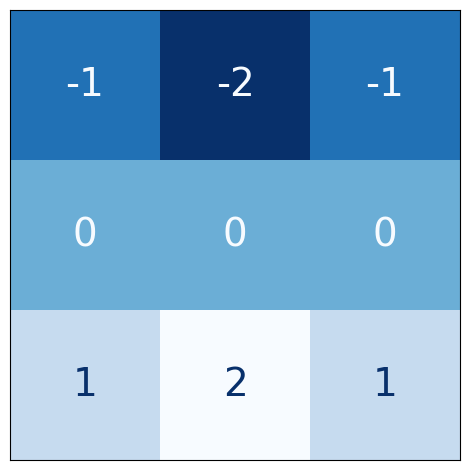

In [43]:
import tensorflow as tf
import matplotlib.pyplot as plt

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

image = circle([64, 64], val=1.0, r_shrink=3)
image = tf.reshape(image, [*image.shape, 1])
# Bottom sobel
kernel = tf.constant(
    [[-1, -2, -1],
     [0, 0, 0],
     [1, 2, 1]],
)

show_kernel(kernel)

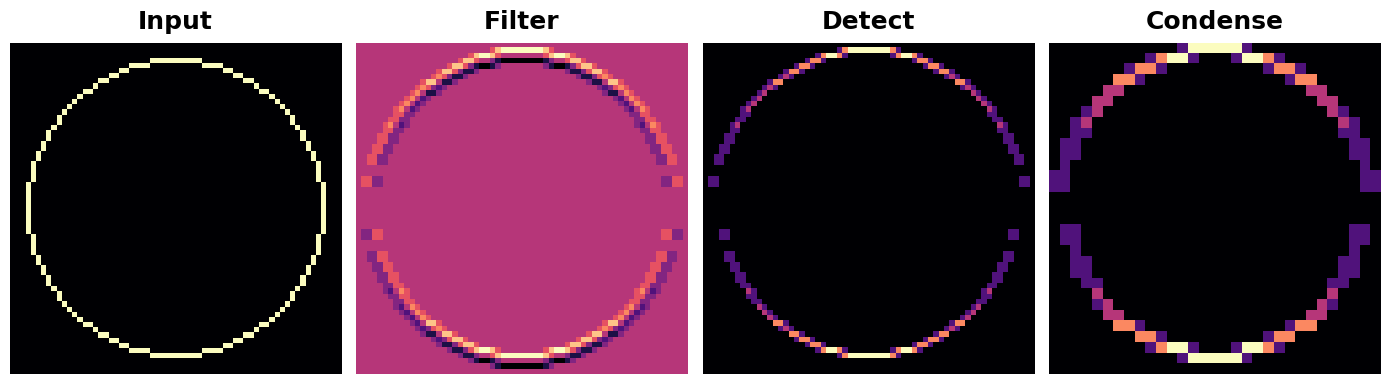

In [45]:
show_extraction(
    image, kernel,

    # Window parameters
    conv_stride=1,
    pool_size=2,
    pool_stride=2,

    subplot_shape=(1, 4),
    figsize=(14, 6),
)

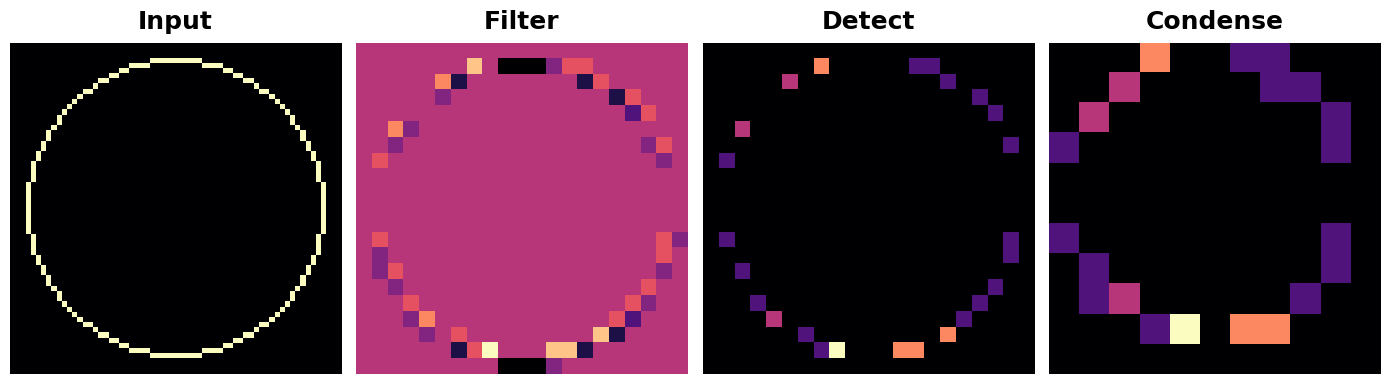

In [47]:
show_extraction(
    image, kernel,

    # Window parameters
    conv_stride=3,
    pool_size=2,
    pool_stride=2,

    subplot_shape=(1, 4),
    figsize=(14, 6),    
)

# Cusom Convnets

In [50]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [52]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([

    # First Convolutional Block
    layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same',
                  # give the input dimensions in the first layer
                  # [height, width, color channels(RGB)]
                  input_shape=[128, 128, 3]),
    layers.MaxPool2D(),

    # Second Convolutional Block
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),

    # Third Convolutional Block
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),

    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=6, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │         196,614 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 291,405 (1.11 MB)

 Trainable params: 291,405 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    ds_train,  
    validation_data=ds_valid,
    epochs=40,
    verbose=0,
)

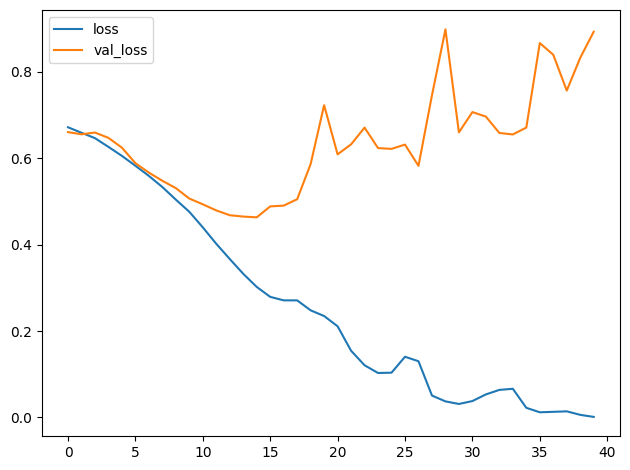

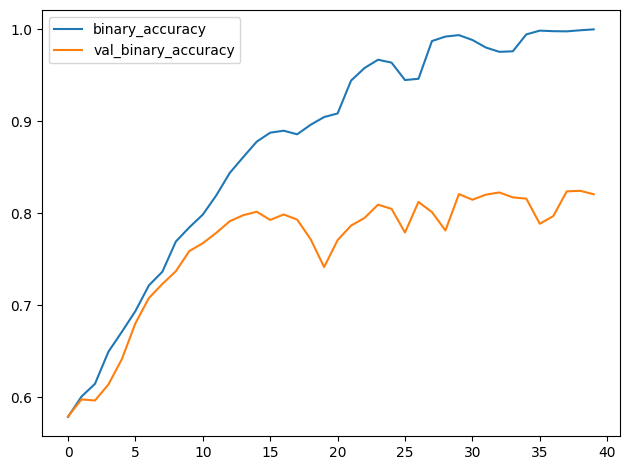

In [55]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();


In [60]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
     interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [70]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

from tensorflow.keras.layers import TFSMLayer

pretrained_base = TFSMLayer(
    'cv-course-models/cv-course-models/vgg16-pretrained-base',
    call_endpoint="serving_default"  # required for SavedModel in Keras 3
)


model = keras.Sequential([
    # ✅ Preprocessing (updated import)
    layers.RandomFlip('horizontal'),
    layers.RandomContrast(0.5),

    # Base model
    pretrained_base,

    # Head
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])
